In [1]:
import os
import dmd
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.linalg import pinv
from scipy.integrate import solve_ivp
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

Integrate $\dot{x}=-x^2$ for three initial conditions.
I use initial conditions 1, 2, and 3 insteady of Hangjun's 1, 100, 800, because the SVD for exact DMD is numerically better.

In [2]:
T=20
dt=0.002
def f(t,x):
    return -x**2
def f2(t,x):
    return -x

num=500
numtraj=5
X=np.zeros((numtraj,int(T/dt)-1,1+num))
Y=np.zeros((numtraj,int(T/dt)-1,1+num))
X2=np.zeros((numtraj,int(T/dt)-1,1+num))
Y2=np.zeros((numtraj,int(T/dt)-1,1+num))
ics=1+0.5*np.arange(numtraj)

library_funcs=[lambda x:x]+[lambda x, n=n: np.cos((n+1)*x) for n in range(1,num//2+1)]+[lambda x, n=n: np.sin((n+1)*x) for n in range(1,num//2+1)]
for i in range(numtraj):
    sol=solve_ivp(f,[0,T],[ics[i]],t_eval=np.arange(int(T/dt))*dt,rtol=1E-12,atol=1E-12)
    sol2=solve_ivp(f2,[0,T],[ics[i]],t_eval=np.arange(int(T/dt))*dt,rtol=1E-12,atol=1E-12)
    t=sol.t
    y=sol.y
    y2=sol2.y
    X[i]=np.array([func(y[0][:-1]) for func in library_funcs]).T
    Y[i]=np.array([func(y[0][1:]) for func in library_funcs]).T
    
    X2[i]=np.array([func(y2[0][:-1]) for func in library_funcs]).T
    Y2[i]=np.array([func(y2[0][1:]) for func in library_funcs]).T

X=np.concatenate(X,axis=0)
Y=np.concatenate(Y,axis=0)
X2=np.concatenate(X2,axis=0)
Y2=np.concatenate(Y2,axis=0)

### Exact resDMD, using code from my Kuramoto analysis

In [4]:
filebase0='data/1ddmd/'
if not os.path.exists(filebase0):
    os.mkdir(filebase0)
os.system('rm %s*'%(filebase0))
verbose=True
filebase=filebase0+'algebraic'
s,u,v,errs=dmd.PCA(X,filebase,verbose,save=False)
try:
    r=np.where(s<s.max() * max(X.shape[0],X.shape[1]) * np.finfo(X.dtype).eps)[0][0]
except:
    r=len(s)
evals,evecs,res,phis,bs=dmd.resDMD(u[:,:r],v[:r,:],s[:r],X,Y,filebase,verbose,save=True)

filebase=filebase0+'exponential'
s2,u2,v2,errs2=dmd.PCA(X2,filebase0,verbose,save=False)
try:
    r2=np.where(s2<s2.max() * max(X2.shape[0],X2.shape[1]) * np.finfo(X2.dtype).eps)[0][0]
except:
    r2=len(s2)
evals2,evecs2,res2,phis2,bs2=dmd.resDMD(u2[:,:r2],v2[:r2,:],s2[:r2],X2,Y2,filebase,verbose,save=True)

nr=26
ni=26
mus1=np.log(evals[np.where(res<1E-3)[0]])/dt
mus2=np.log(evals2[np.where(res2<1E-3)[0]])/dt
mus=np.concatenate([mus1,mus2])
scaler=1.1*np.max(np.abs(np.real(mus)))
scalei=1*1*np.max(np.abs(np.imag(mus)))
if scalei>np.pi/dt:
    print('time step too small for pseudospectral resolution')
    scalei=np.min([np.pi/dt,scalei])

murs=-scaler+2*scaler*np.arange(nr)/(nr-1)
muis=-scalei+2*scalei*np.arange(ni)/(ni-1)

filebase=filebase0+'algebraic'
inds=np.intersect1d(np.where(np.abs(np.real(np.log(evals)/dt))<scaler)[0],np.where(np.abs(np.imag(np.log(evals)/dt))<scalei)[0])
zs=np.exp((murs[:,np.newaxis]+1j*muis[np.newaxis,:]).ravel()*dt)
zs,pseudo,xis,its=dmd.resDMDpseudo(u[:,:r],v[:r,:],s[:r],X,Y,zs,evals,evecs,filebase,verbose,save=True)

filebase=filebase0+'exponential'
inds2=np.intersect1d(np.where(np.abs(np.real(np.log(evals2)/dt))<scaler)[0],np.where(np.abs(np.imag(np.log(evals2)/dt))<scalei)[0])
zs2=np.exp((murs[:,np.newaxis]+1j*muis[np.newaxis,:]).ravel()*dt)
zs2,pseudo2,xis2,its2=dmd.resDMDpseudo(u2[:,:r2],v2[:r2,:],s2[:r2],X2,Y2,zs2,evals2,evecs2,filebase,verbose,save=True)


svd runtime: 44.35699207894504
full rank: 252
eig runtime: 0.2706237069796771
residue runtime: 0.4626738119404763
svd runtime: 21.063183247111738
full rank: 266
eig runtime: 0.1589589931536466
residue runtime: 0.5395508881192654
0.998521	-2.228309	0.0000002
pseudospectra runtime: 266.71615987387486
0.998521	-2.228309	0.0000002
pseudospectra runtime: 299.1021721479483


In [5]:
filebase0='data/1ddmd/'

filebase=filebase0+'algebraic'
evals=np.load(filebase+'evals.npy')
evecs=np.load(filebase+'evecs.npy')
res=np.load(filebase+'res.npy')
phis=np.load(filebase+'phis.npy')
bs=np.load(filebase+'bs.npy')
zs=np.load(filebase+'zs.npy')
pseudo=np.load(filebase+'pseudo.npy')

filebase=filebase0+'exponential'
evals2=np.load(filebase+'evals.npy')
evecs2=np.load(filebase+'evecs.npy')
res2=np.load(filebase+'res.npy')
phis2=np.load(filebase+'phis.npy')
bs2=np.load(filebase+'bs.npy')
zs2=np.load(filebase+'zs.npy')
pseudo2=np.load(filebase+'pseudo.npy')

[1.e-09 1.e-06 1.e-03 1.e+00 1.e+03 1.e+06]


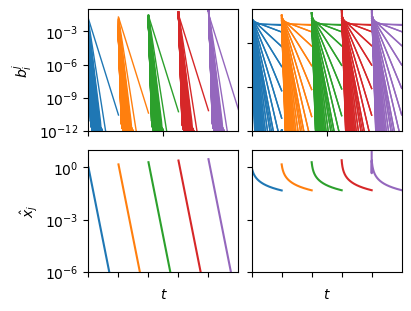

In [6]:
t=np.arange(len(bs))*dt
mus2=np.log(evals2)/dt
inds2=np.intersect1d(np.where(res2<1E-8)[0],np.where(np.real(mus2)<-1E-8)[0])
mus=np.log(evals)/dt
inds=np.intersect1d(np.where(res<1E-8)[0],np.where(np.real(mus)<-1E-8)[0])
inds3=np.where(np.real(mus[inds])>-10)[0]
inds4=np.where(np.real(mus2[inds2])>-10)[0]

plt.subplots(2,2,figsize=(4,3),layout='constrained')

plt.subplot(2,2,1)
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(bs2[n*len(t)//numtraj:(n+1)*len(t)//numtraj,inds2[inds4]]),c=colors[n],lw=1)

plt.yscale('log')
plt.ylim(1E-12,1E-1)
plt.xlim(t[0],t[-1])
plt.xticks(plt.gca().get_xticks(),['']*len(plt.gca().get_xticks()))
plt.xlim(t[0],t[-1])
plt.ylabel('$b_i^j$')

plt.subplot(2,2,2)
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(bs[n*len(t)//numtraj:(n+1)*len(t)//numtraj,inds[inds3]]),c=colors[n],lw=1)

plt.yscale('log')
plt.ylim(1E-12,1E-1)
plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
plt.ylim(1E-12,1E-1)
plt.xlim(t[0],t[-1])
plt.xticks(plt.gca().get_xticks(),['']*len(plt.gca().get_xticks()))
plt.xlim(t[0],t[-1])

X_reconstruct=np.zeros(X.shape)
X_reconstruct2=np.zeros(X2.shape)
for n in range(numtraj):
    n0=X.shape[0]//numtraj*n
    X_reconstruct[n0:n0+X.shape[0]//numtraj]=np.real((bs[n0,inds]*np.linalg.pinv(phis)[inds].T).dot(evals[inds,np.newaxis]**np.arange(X.shape[0]//numtraj)[np.newaxis,:])).T
    X_reconstruct2[n0:n0+X.shape[0]//numtraj]=np.real((bs2[n0,inds2]*np.linalg.pinv(phis2)[inds2].T).dot(evals2[inds2,np.newaxis]**np.arange(X.shape[0]//numtraj)[np.newaxis,:])).T

plt.subplot(2,2,3)
for n in range(numtraj):
    # plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],X2[n*len(t)//numtraj:(n+1)*len(t)//numtraj,0],c=colors[n])
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],X_reconstruct2[n*len(t)//numtraj:(n+1)*len(t)//numtraj,0],c=colors[n])
plt.yscale('log')
plt.xlim(t[0],t[-1])
plt.ylim(1E-6,1E1)
plt.ylabel('$\hat{x}_j$')
plt.xlabel('$t$')
plt.xticks(t[::len(t)//numtraj],['']*numtraj)
ytics=plt.gca().get_yticks()
plt.gca().set_yticks(ytics)
plt.ylim(1E-6,1E1)

plt.subplot(2,2,4)
for n in range(numtraj):
    # plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],X[n*len(t)//numtraj:(n+1)*len(t)//numtraj,0])
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],X_reconstruct[n*len(t)//numtraj:(n+1)*len(t)//numtraj,0],c=colors[n])
plt.yscale('log')
plt.xlim(t[0],t[-1])
plt.ylim(1E-6,1E1)

plt.xticks(t[::len(t)//numtraj],['']*numtraj)
plt.gca().set_yticks(ytics,['']*len(ytics))
plt.ylim(1E-6,1E1)
print(plt.gca().get_yticks())
plt.xlabel('$t$')

plt.savefig('1ddmd1.pdf')
plt.show()

The pseudospectrum and mode amplitudes look pretty nice

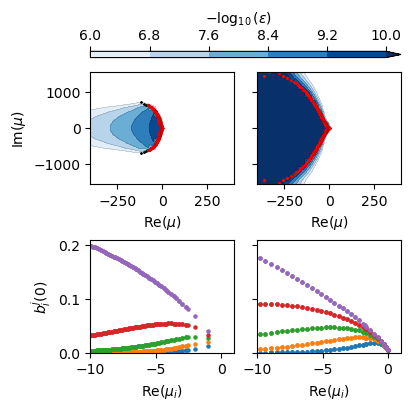

In [7]:
resmin=1E-6
resmax=1E-10
rescrit=1E-8
levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5

inds3=np.where(np.real(mus[inds])>-10)[0]
inds4=np.where(np.real(mus2[inds2])>-10)[0]
scale=1.05*np.max(np.concatenate([np.abs(bs[:,inds[inds3]]).ravel(),np.abs(bs2[:,inds2[inds4]]).ravel()]))


fig,axs=plt.subplots(2,2,figsize=(4,4),layout='constrained')


plt.subplot(2,2,1)
cs1 = plt.gca().tricontourf(np.real(np.log(zs2)/dt),np.imag(np.log(zs2)/dt),np.log(1/np.array(pseudo2))/np.log(10),levels=levels,cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)

plt.scatter(np.real(mus2),np.imag(mus2),c='black',s=1)
plt.scatter(np.real(mus2)[inds2],np.imag(mus2)[inds2],c='red',s=2)
plt.xlim(-scaler,scaler)
plt.ylim(-scalei,scalei)
plt.xlabel(r'$\mathrm{Re}(\mu)$')
plt.ylabel(r'$\mathrm{Im}(\mu)$')
# plt.title(r'$\dot{x}=-x$')

plt.subplot(2,2,3)

for n in range(numtraj):
    plt.scatter(np.real(mus2)[inds2],np.abs(bs2[n*len(t)//numtraj])[inds2],s=5)

# plt.scatter(np.real(mus2)[inds2],np.abs(bs2[0])[inds2],s=5)
plt.xlim(-10,1)
plt.ylim(0,scale)
plt.xlabel(r'$\mathrm{Re}(\mu_i)$')
plt.ylabel(r'$b_i^j(0)$')



plt.subplot(2,2,2)
cs1 = plt.gca().tricontourf(np.real(np.log(zs)/dt),np.imag(np.log(zs)/dt),np.log(1/np.array(pseudo))/np.log(10),levels=levels,cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)
fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')

plt.scatter(np.real(mus),np.imag(mus),c='black',s=1)
plt.scatter(np.real(mus)[inds],np.imag(mus)[inds],c='red',s=2)
plt.xlim(-scaler,scaler)
plt.ylim(-scalei,scalei)
plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
plt.ylim(-scalei,scalei)
plt.xlabel(r'$\mathrm{Re}(\mu)$')
# plt.title(r'$\dot{x}=-x^2$')

plt.subplot(2,2,4)

for n in range(numtraj):
    plt.scatter(np.real(mus)[inds],np.abs(bs[n*len(t)//numtraj])[inds],s=5)

# plt.scatter(np.real(mus)[inds],np.abs(bs[0])[inds],s=5)
plt.xlim(-10,1)
plt.ylim(0,scale)
plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
plt.ylim(0,scale)
plt.xlabel(r'$\mathrm{Re}(\mu_i)$')

plt.savefig('1ddmd2.pdf')
plt.show()

0
LinregressResult(slope=4.0756892585661596e-12, intercept=-5.409839139666656, rvalue=0.9264605114839997, pvalue=nan, stderr=nan, intercept_stderr=nan)


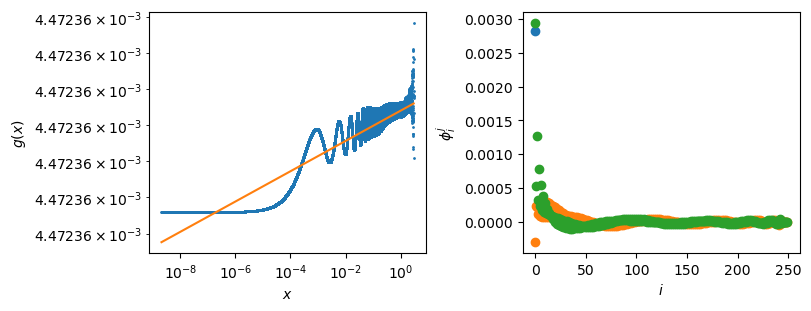

1
LinregressResult(slope=0.9999993854121895, intercept=-4.3164884290225345, rvalue=0.9999999999999231, pvalue=nan, stderr=nan, intercept_stderr=nan)


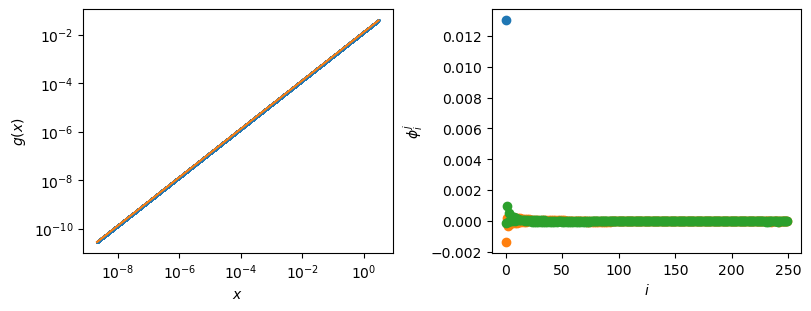

2
LinregressResult(slope=2.005209931869892, intercept=-4.894271374284673, rvalue=0.999999999986435, pvalue=nan, stderr=nan, intercept_stderr=nan)


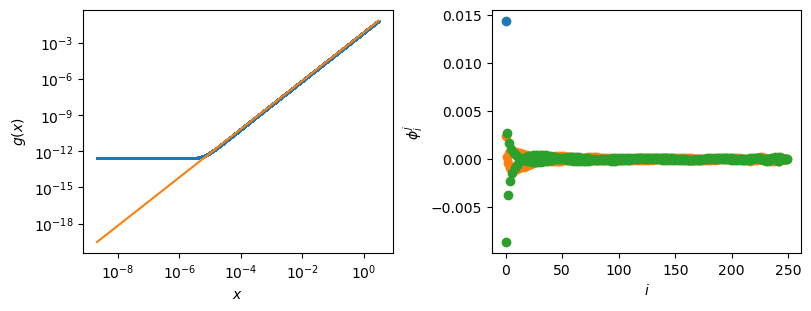

3
LinregressResult(slope=2.5246681874548336, intercept=-5.291596858410694, rvalue=0.9999999999929602, pvalue=nan, stderr=nan, intercept_stderr=nan)


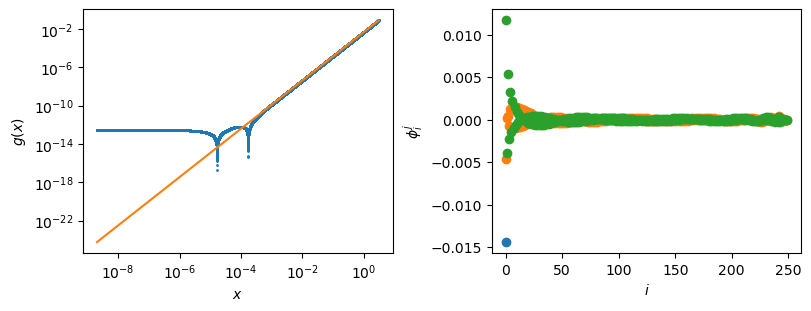

4
LinregressResult(slope=2.715331899901436, intercept=-5.447002097157676, rvalue=0.9999999999989195, pvalue=nan, stderr=nan, intercept_stderr=nan)


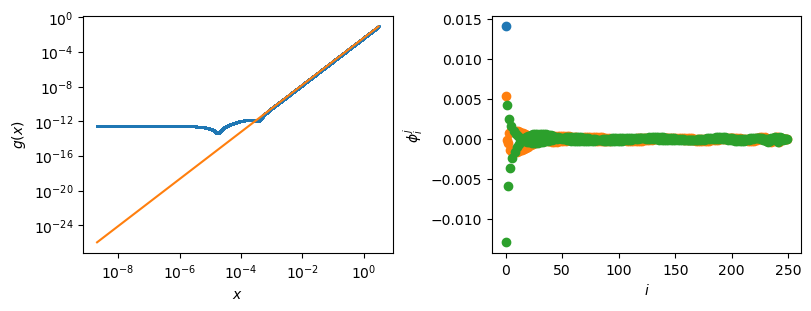

In [122]:
# The five leading Koopman mode in the exponential case; they approximate powers of x, as expected
for n in range(5):
    print(n)

    i=np.argsort(res2)[n]
    tinds=np.where(np.abs(bs2[:,i])>1E-8)
    reg=linregress(np.log(X2[tinds,0]),np.log(np.abs(bs2[tinds,i])))
    xs=np.min(X2[:,0])+(np.max(X2[:,0])-np.min(X2[:,0]))*np.arange(10000)/10000
    print(reg)

    plt.subplots(1,2,figsize=(8,3),layout='constrained')
    plt.subplot(1,2,1)
    plt.plot(xs,np.exp(reg.intercept)*xs**reg.slope,c=colors[1])
    plt.scatter(X2[:,0],np.abs(bs2[:,i]),s=1)
    # plt.scatter(X2[:,0],np.imag(bs2[:,i]),s=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$x$')
    plt.ylabel('$g(x)$')
    

    plt.subplot(1,2,2)
    plt.plot(np.real(phis2[:1,i]),marker='o',lw=0)
    plt.plot(np.real(phis2[1:num//2+1,i]),marker='o',lw=0)
    plt.plot(np.real(phis2[num//2+1:,i]),marker='o',lw=0)
    plt.xlabel('$i$')
    plt.ylabel('$\phi_i^j$')
    plt.show()

0


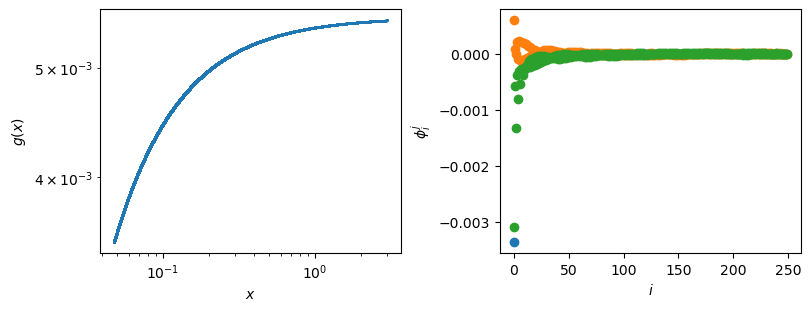

1


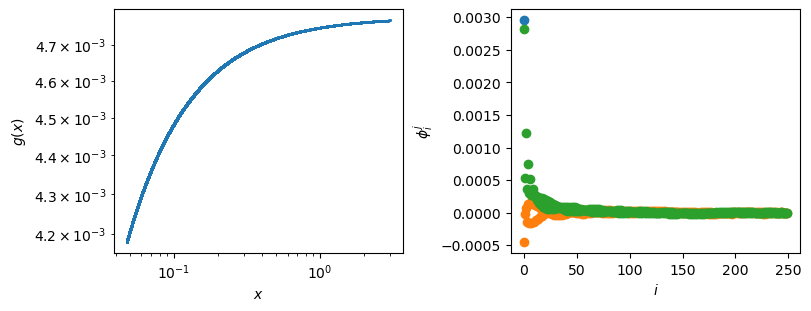

2


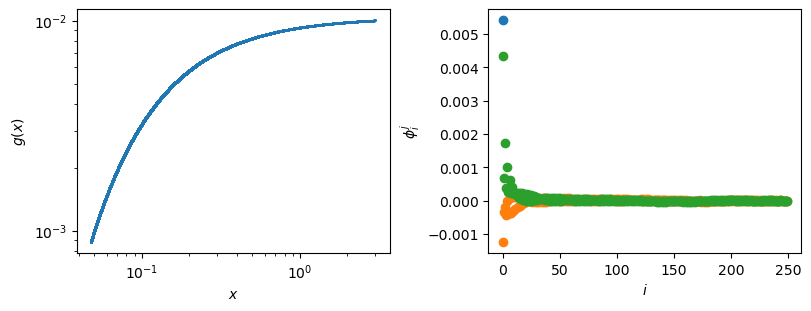

3


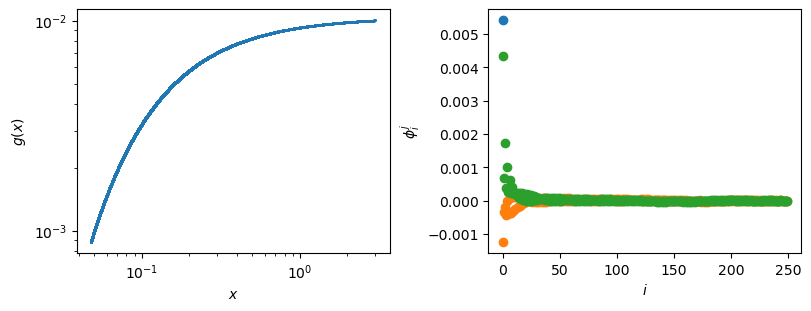

4


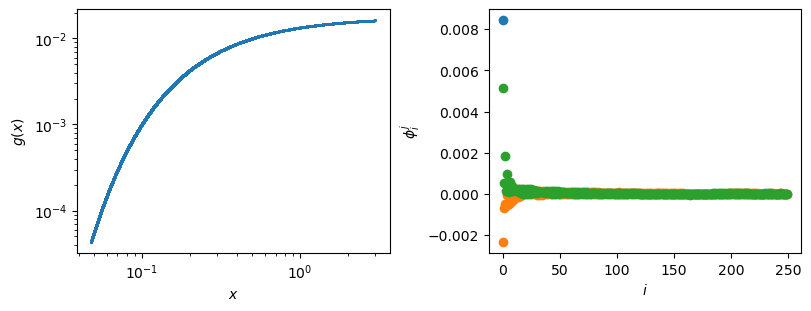

In [73]:
# The five leading Koopman mode in the algebraic case  
for n in range(5):
    print(n)
    i=np.argsort(res)[n]
    plt.subplots(1,2,figsize=(8,3),layout='constrained')
    plt.subplot(1,2,1)
    plt.scatter(X[:,0],np.abs(bs[:,i]),s=1)
    # plt.scatter(X[:,0],np.imag(bs[:,i]),s=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$x$')
    plt.ylabel('$g(x)$')
    

    plt.subplot(1,2,2)
    plt.plot(np.real(phis[:1,i]),marker='o',lw=0)
    plt.plot(np.real(phis[1:num//2+1,i]),marker='o',lw=0)
    plt.plot(np.real(phis[num//2+1:,i]),marker='o',lw=0)
    plt.xlabel('$i$')
    plt.ylabel('$\phi_i^j$')
    plt.show()

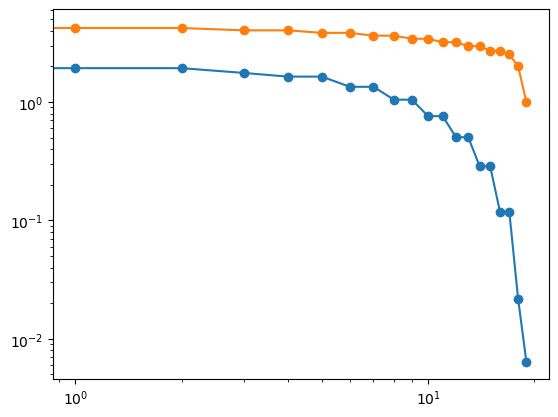

In [136]:
plt.plot(-np.sort(np.real(mus[inds]))[-20:],marker='o')
plt.yscale('log')
plt.xscale('log')
plt.plot(-np.sort(np.real(mus2[inds2]))[-20:],marker='o')
plt.yscale('log')
plt.xscale('log')

/tmp/ipykernel_293780/2773207011.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/np.arange(20),-np.sort(np.real(mus[inds]))[-20:],marker='o')


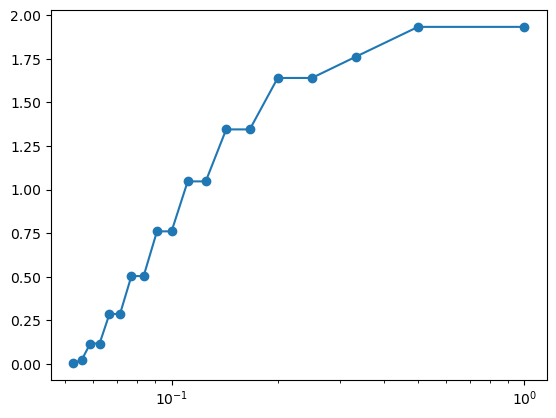

In [139]:
# plt.plot(1/np.arange(20),np.sort(-np.real(mus2[inds2]))[:20],marker='o')
plt.plot(1/np.arange(20),-np.sort(np.real(mus[inds]))[-20:],marker='o')

# plt.yscale('log')
plt.xscale('log')

In [133]:
linregress(np.arange(20),np.sort(-np.real(mus[inds]))[:20])

LinregressResult(slope=0.12147281978483783, intercept=-0.18990607984228214, rvalue=0.9913476221087987, pvalue=2.501566951784128e-17, stderr=0.0037910382876963117, intercept_stderr=0.04213001845951713)

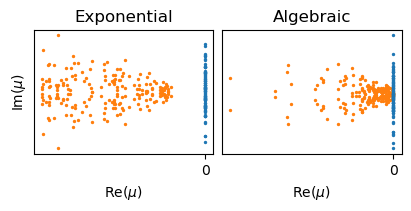

In [8]:
plt.subplots(1,2,figsize=(4,2),layout='constrained')

np.random.seed(1)
plt.subplot(1,2,1)
numosc=100
numdecay=100
yosc=np.random.normal(0,10,size=numosc)
xosc=np.zeros(numosc)

xdecay=np.random.uniform(-5,-1,size=numdecay)
ydecay=np.random.normal(0,5*(-1-xdecay)**0.5)
plt.scatter(xosc,yosc,s=2,c=colors[0])
plt.scatter(xdecay,ydecay,s=2,c=colors[1])
plt.scatter(xdecay,-ydecay,s=2,c=colors[1])
plt.xlabel('$\mathrm{Re}(\mu)$')
plt.ylabel('$\mathrm{Im}(\mu)$')
plt.gca().set_yticks([])
plt.gca().set_xticks([0])
plt.title('Exponential')


plt.subplot(1,2,2)
numosc=100
numdecay=100
yosc=np.random.normal(0,10,size=numosc)
xosc=np.zeros(numosc)

xdecay=-np.random.exponential(1,size=numdecay)
ydecay=np.random.normal(0,5*(-xdecay)**0.5)
plt.scatter(xosc,yosc,s=2,c=colors[0],zorder=5)
plt.scatter(xdecay,ydecay,s=2,c=colors[1],zorder=4)
plt.scatter(xdecay,-ydecay,s=2,c=colors[1],zorder=4)
plt.gca().set_yticks([])
plt.gca().set_xticks([0])
plt.title('Algebraic')
plt.xlabel('$\mathrm{Re}(\mu)$')
plt.savefig('schematic.pdf')
plt.show()